In [15]:
import random
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

### I want to try serial dependece by weighted average in internal representation of confidence

In [16]:
###### FLEMING'S FUNCTION MODIFIED
def compute_meta_conf_serialdependence(xp, a, sigma_act, sigma_conf, rho):
    
    dhat = np.array([-1, 1])
    mu_x_xp_dhat = np.zeros((2, len(xp)))
    var_x_xp_dhat = np.zeros(len(xp))
    rho_vec = np.full(len(xp), rho)
    sigA_vec = np.full(len(xp), sigma_act)
    sigP_vec = np.full(len(xp), sigma_conf)
    
    Tol = 10e-4

    for dhati in range(2):
        dhat_vec = np.full(len(xp), dhat[dhati])
        
        mu_x_xp_dhat[dhati, :] = dhat_vec + (sigA_vec / sigP_vec) * rho_vec * (xp - dhat_vec)
        var_x_xp_dhat = (1 - rho_vec**2) * sigA_vec**2
        
        if a == 1:
            p_a_dhat_xp = 1 - norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        else:
            p_a_dhat_xp = norm.cdf(0, mu_x_xp_dhat[dhati, :], np.sqrt(var_x_xp_dhat))
        
        lik_d = norm.pdf(xp, dhat_vec, sigP_vec)
        
        if dhati == 0:
            p_a_dhat_xp_full = p_a_dhat_xp
            lik_d_full = lik_d
        else:
            p_a_dhat_xp_full = np.vstack((p_a_dhat_xp_full, p_a_dhat_xp))
            lik_d_full = np.vstack((lik_d_full, lik_d))
    
    # manage probability
    p_a_dhat_xp_full = np.clip(p_a_dhat_xp_full, Tol, None)
    lik_d_full = np.clip(lik_d_full, Tol, None)
    
    lik_d_full = lik_d_full / np.sum(lik_d_full, axis=0, keepdims=True)
    p_dhat_xp_a = p_a_dhat_xp_full * lik_d_full
    p_dhat_xp_a = p_dhat_xp_a / np.sum(p_dhat_xp_a, axis=0, keepdims=True)
    
    # Conf = p(a=d)
    if a == 1:
        conf = p_dhat_xp_a[1, :]
    else:
        conf = p_dhat_xp_a[0, :]
    
    return conf

In [17]:
theta = [0/6, 1/6, 2/6, 3/6, 4/6, 5/6, 6/6] # I changed a little, because is very easy so far 
sigmaAct = 1  # 1
sigmaConf = 1 # 1
rho = 0.5 # 0.5
bigSigma = np.array([[sigmaAct**2, rho * sigmaAct * sigmaConf], [rho * sigmaAct * sigmaConf, sigmaConf**2]])

# serial dependence weight. alpha = 3 and beta = 7 gives a E[p] of 0.3 given the ecuation alpha/(alpha+beta)
serial_dependence_weight_alpha = 3 
serial_dependence_weight_beta = 7

N = 1000  # N trials

xa = np.empty(N)
xp = np.empty(N)
xp_serialDependence = np.full( N, 111.0)
d = np.empty(N)
a = np.empty(N)
secondOrder_mean_cor = np.empty(N)
secondOrder_mean_cor_serialDependence =  np.full( N, 111.0)
last_xp = np.empty(N)
first_trial = True

for i in range(N):
    current_theta = random.choice(theta) 
    
    d[i] = 1 if np.random.rand() > 0.5 else -1
    
    r = multivariate_normal.rvs(mean=[d[i] * current_theta, d[i] * current_theta], cov=bigSigma)
    
    xa[i] = r[0]
    xp[i] = r[1]
    
    if xa[i] > 0:
        a[i] = 1
        flip_a = 1
    else:
        a[i] = -1
        flip_a = 0

    secondOrder_mean_cor[i] = compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]
    
    if first_trial == False:
        p_serial_dependence = np.random.beta(serial_dependence_weight_alpha, serial_dependence_weight_beta, 1)[0]
        secondOrder_mean_cor_serialDependence[i] = (
            p_serial_dependence * secondOrder_mean_cor_serialDependence[i-1] + 
            (1-p_serial_dependence) * compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]
        )
    else:
        secondOrder_mean_cor_serialDependence[i] = compute_meta_conf_serialdependence(np.array([xp[i]]), flip_a, sigmaAct, sigmaConf, rho)[0]
 
    first_trial = False
    


In [18]:
secondOrder_mean_cor_serialDependence[0:10]

array([0.92407545, 0.92785029, 0.89083579, 0.92683247, 0.97126111,
       0.86884079, 0.84007369, 0.74694665, 0.71370967, 0.91945625])

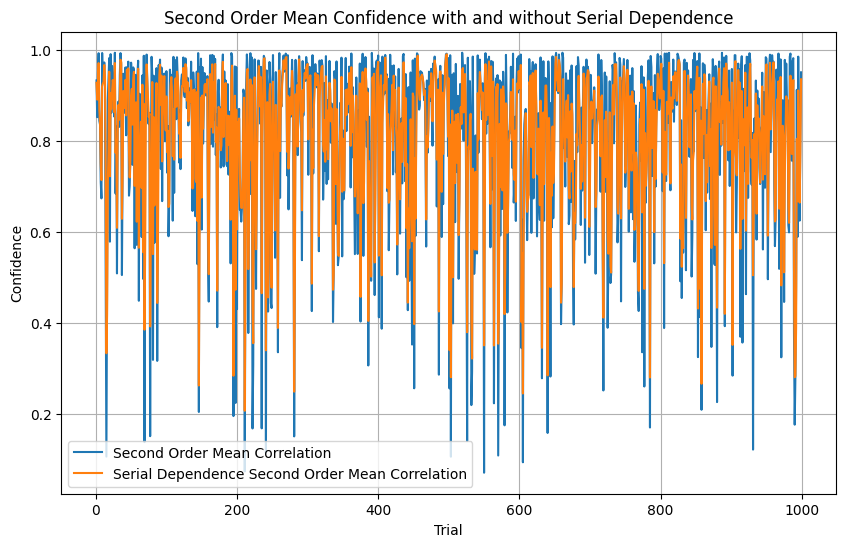

In [19]:
# Eliminar el primer valor de secondOrder_mean_cor
secondOrder_mean_cor_adj = secondOrder_mean_cor[1:]
secondOrder_mean_cor_serialDependence_adj = secondOrder_mean_cor_serialDependence[1:]

# Crear el plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, N), secondOrder_mean_cor_adj, label='Second Order Mean Correlation')
plt.plot(range(1,N), secondOrder_mean_cor_serialDependence_adj, label='Serial Dependence Second Order Mean Correlation')
plt.xlabel('Trial')
plt.ylabel('Confidence')
plt.title('Second Order Mean Confidence with and without Serial Dependence')
plt.legend()
plt.grid(True)
plt.show()

### Run a linear regression model to predict trial i based on trial i-1

In [20]:

df = pd.DataFrame({'current': secondOrder_mean_cor_adj})
df['previous'] = df['current'].shift(1)

# Eliminar filas con valores NaN (la primera fila en este caso)
df = df.dropna()

# Paso 2: Preparar los datos para la regresión
X = df['previous']  # Característica (valor i-1)
y = df['current']   # Objetivo (valor i)

# Añadir una constante (intercepto) a X
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Mostrar el resumen del modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                current   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1205
Date:                Wed, 24 Jul 2024   Prob (F-statistic):              0.729
Time:                        09:18:26   Log-Likelihood:                 193.22
No. Observations:                 998   AIC:                            -382.4
Df Residuals:                     996   BIC:                            -372.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7944      0.026     30.294      0.0

In [21]:

df = pd.DataFrame({'current': secondOrder_mean_cor_serialDependence_adj})
df['previous'] = df['current'].shift(1)

# Eliminar filas con valores NaN (la primera fila en este caso)
df = df.dropna()

# Paso 2: Preparar los datos para la regresión
X = df['previous']  # Característica (valor i-1)
y = df['current']   # Objetivo (valor i)

# Añadir una constante (intercepto) a X
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Mostrar el resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                current   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     80.66
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.32e-18
Time:                        09:18:26   Log-Likelihood:                 497.60
No. Observations:                 998   AIC:                            -991.2
Df Residuals:                     996   BIC:                            -981.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5832      0.025     23.410      0.0